In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly
import fitsio

from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import plot, iplot
from random import randint

import plotly.graph_objs as go


%matplotlib notebook
%run './plot_setup.py'

In [2]:
A = fitsio.FITS('./delta_transmission_RMplate.fits')
A[0].read_header()


SIMPLE  =                    T / file does conform to FITS standard
BITPIX  =                   16 / number of bits per data pixel
NAXIS   =                    0 / number of data axes
EXTEND  =                    T / FITS dataset may contain extensions
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H

In [3]:
# extract the ra, dec and quasar redshift for each object
# append a dummy index at the first location since the table data in the fits
# file starts at index 1
ra_list, dec_list, z_list = [np.nan], [np.nan], [np.nan]

for i in range(1, 8733):
    hdr = A[i].read_header()
    ra_list.append(hdr['RA'])
    dec_list.append(hdr['DEC'])
    z_list.append(hdr['Z'])

ra, dec = np.deg2rad(np.array(ra_list)), np.deg2rad(np.array(dec_list))
mean_ra, mean_dec = np.nanmean(ra), np.nanmean(dec)

# The k-vector pointing along the direction of LOS
k_par = np.array([np.sin(mean_dec) * np.cos(mean_ra), np.sin(mean_dec) * np.sin(mean_ra), np.cos(mean_dec)])

# Vector perpendicular to the above vector over which we rotate the co-ordinate system
k_perp = np.array([-np.sin(mean_ra), np.cos(mean_ra), 0])

# Rotation direction - Cross product matrix
K = np.array([
    [0, -k_perp[2], k_perp[1]],
    [k_perp[2], 0, -k_perp[0]],
    [-k_perp[1], k_perp[0], 0]
    ])

# ADOPTED FROM: https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula
# Rotation Matrix to rotate the basis vectors
R = np.eye(3) + np.sin(mean_dec) * K + (1 - np.cos(mean_dec)) * np.matmul(K, K)

# Rotation Matrix to rotate the points vectors
Q = np.eye(3) - np.sin(mean_dec) * K + (1 - np.cos(mean_dec)) * np.matmul(K, K)

<IPython.core.display.Javascript object>


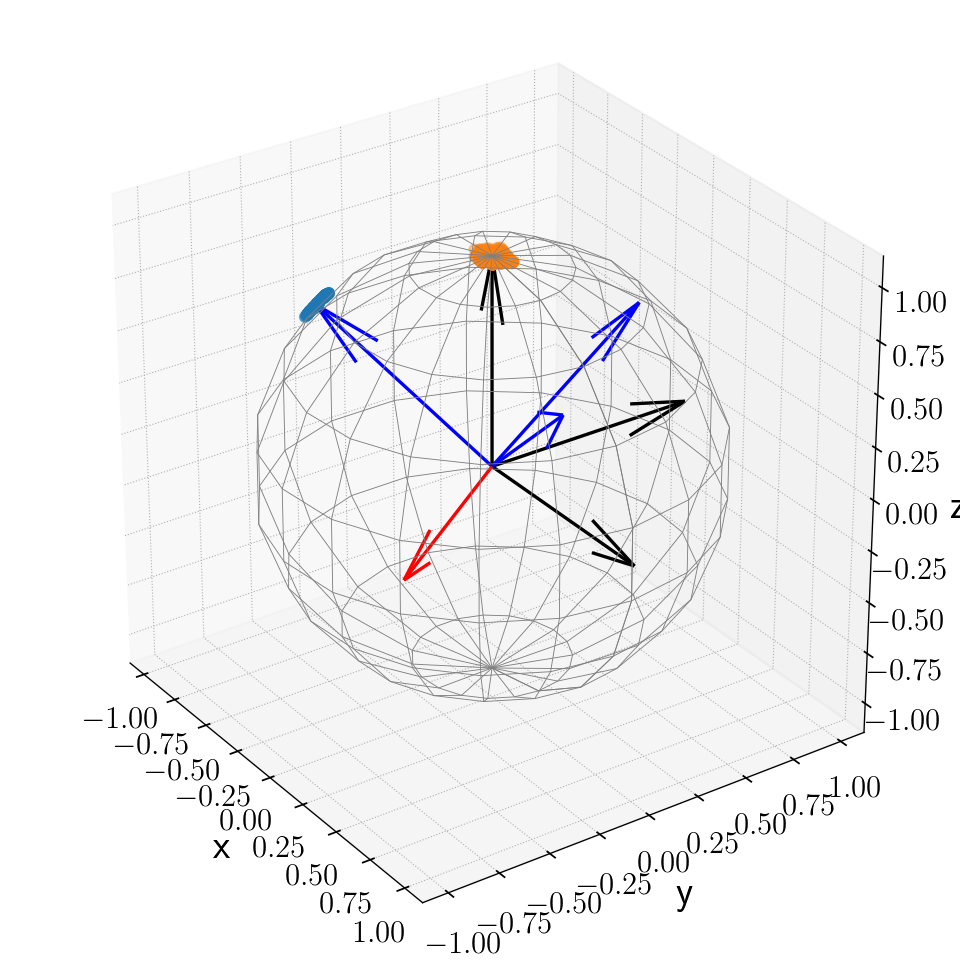

In [5]:
# THIS CELL IS JUST A TEST TO SEE IF THE ROTATION MATRICES ABOVE ARE CORRECT

# Basic vectors
origin = [0] * 3
x_axis, y_axis, z_axis = [1, 0, 0], [0, 1, 0], [0, 0, 1]

# The points on the celestial sphere
x = np.sin(dec) * np.cos(ra)
y = np.sin(dec) * np.sin(ra)
z = np.cos(dec)

# Rotate the basis vector to see if what we get is correct
z_rot = R.dot(z_axis)
x_rot = R.dot(x_axis)
y_rot = R.dot(y_axis)


# draw sphere
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x_s = np.cos(u)*np.sin(v)
y_s = np.sin(u)*np.sin(v)
z_s = np.cos(v)
ax.plot_wireframe(x_s, y_s, z_s, color="gray", lw=0.4)

# Plot a subset of the points
sub_sam = np.random.randint(low=1, high=8732, size=100)

# shape is (sub_sam, 3)
points = np.array([x[sub_sam], y[sub_sam], z[sub_sam]]).T

# Rotate the points
rot_points = Q.dot(points.T)

# Plot the original points
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
# Plot the rotated points - these will be our data
ax.scatter(rot_points[0], rot_points[1], rot_points[2])

# ax.scatter(rot_data[0], rot_data[1], rot_data[2])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.quiver(*origin, *x_axis, color='k')
ax.quiver(*origin, *y_axis, color='k')
ax.quiver(*origin, *z_axis, color='k')

ax.quiver(*origin, *x_rot, color='b')
ax.quiver(*origin, *y_rot, color='b')
ax.quiver(*origin, *z_rot, color='b')


# ax.quiver(*origin, *k_par, color='r')
ax.quiver(*origin, *k_perp, color='r')

plt.show()

In [6]:
# Read a subset of the data and store it as an array
x_arr = []
y_arr = []
z_arr = []
f_arr = []

n_skewers = 100

for i in np.random.randint(low=1, high=8732, size=n_skewers):
    tb1 = A[i].read()
    r, field = tb1['RCOMOV'], tb1['DELTA_T']

    x = np.sin(dec[i]) * np.cos(ra[i]) * r
    y = np.sin(dec[i]) * np.sin(ra[i]) * r
    z = np.cos(dec[i]) * r
    
    x_arr = np.hstack((x_arr, x))
    y_arr = np.hstack((y_arr, y))
    z_arr = np.hstack((z_arr, z))
    f_arr = np.hstack((f_arr, field))
    
# Rotate the data-points
data = np.array([x_arr, y_arr, z_arr])
rot_data = Q.dot(data)

In [ ]:
# # Shift the center of the box to zero + 4 h^-1 Mpc
# x_arr -= (x_arr.min() - 5)
# y_arr -= (y_arr.min() - 5)
# z_arr -= (z_arr.min() - 5)